# Trying to find the unit circle

A small example to demonstrate EDO's capacity to optimise a simple function:

$$
f(X) = \max_{j, k} \left\{%
    \text{Var}\left(X_{j}\right) - \max_{i} \left|X_{i, k} - 1\right|
\right\}
$$

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

import edo
from edo.pdfs import Distribution, Uniform

plt.style.use("seaborn-colorblind")
%matplotlib inline

In [2]:
class RadiusUniform(Uniform):
    """ A Uniform child for capturing the radius of a point in the circle. """

    name = "RadiusUniform"
    dtype = "float"
    param_limits = {}

    def __init__(self):

        lower = np.random.uniform(*self.param_limits["bounds"])
        upper = np.random.uniform(lower, max(self.param_limits["bounds"]))
        self.bounds = [lower, upper]


class AngleUniform(Uniform):
    """ A Uniform child for capturing the angle of a point in the circle. """

    name = "AngleUniform"
    dtype = "float"
    param_limits = {}

    def __init__(self):

        lower = np.random.uniform(*self.param_limits["bounds"])
        upper = np.random.uniform(lower, max(self.param_limits["bounds"]))
        self.bounds = [lower, upper]


def fitness(df):
    """ Determine the similarity of the dataframe to the unit circle. """

    return max(
        df[0].var() - (df[1] - 1).abs().max(),
        df[1].var() - (df[0] - 1).abs().max()
    )
        

def split_dataframe(individual):

    df, metadata = individual
    families = [m["name"] for m in metadata]
    radii = df[families.index("RadiusUniform")]
    angles = df[families.index("AngleUniform")]

    return radii, angles

In [3]:
pop_histories, fit_histories = [], []
for seed in range(5):
    RadiusUniform.param_limits["bounds"] = [0, 1]
    AngleUniform.param_limits["bounds"] = [-2 * np.pi, 2 * np.pi]

    pops, fits = edo.run_algorithm(
        fitness=fitness,
        size=100,
        row_limits=[30, 100],
        col_limits=[(1, 1), (1, 1)],
        families=[RadiusUniform, AngleUniform],
        max_iter=10,
        best_prop=0.1,
        mutation_prob=0.01,
        maximise=True,
        seed=seed,
    )

    fits["seed"] = seed
    pop_histories.append(pops)
    fit_histories.append(fits)

In [4]:
fit_history = pd.concat(fit_histories)

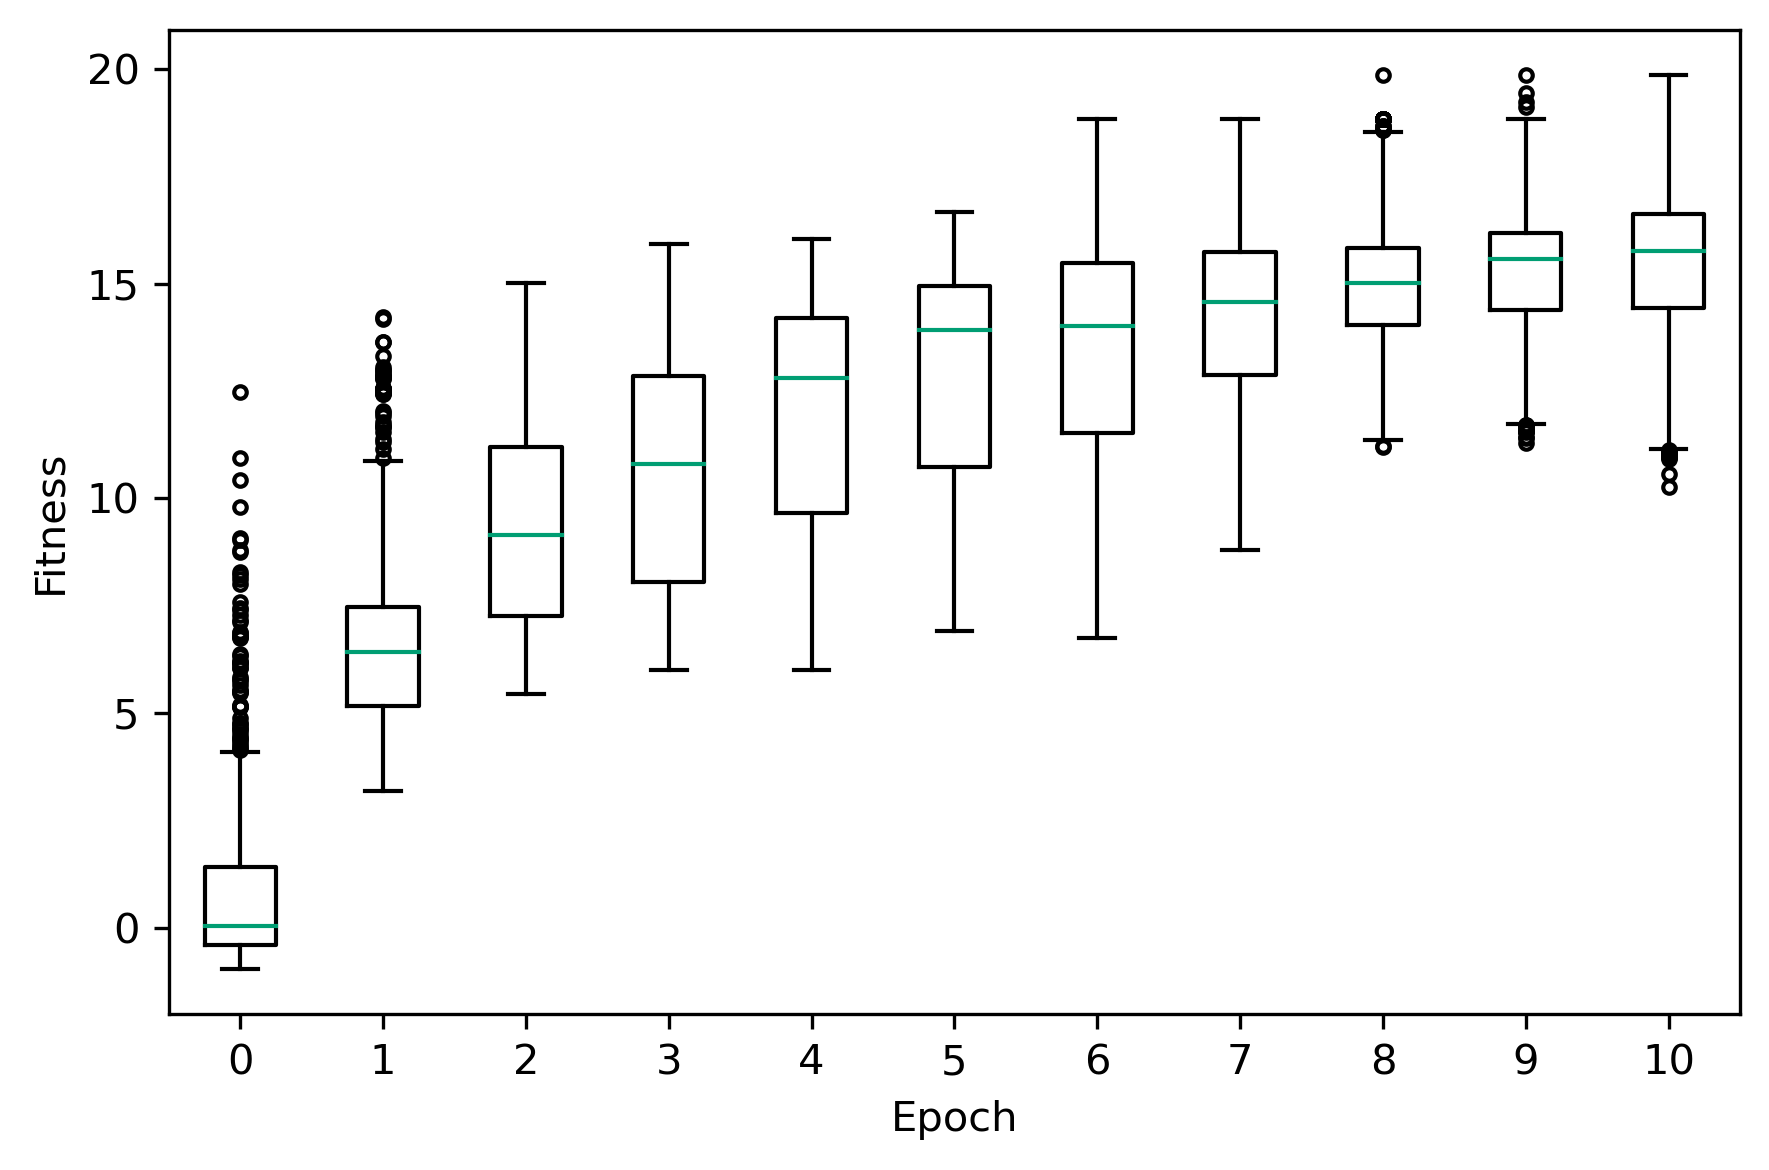

In [5]:
_, ax = plt.subplots(dpi=300)

fit = fit_history[fit_history["generation"].isin(range(0, 11, 1))]

xticklabels = []
for pos, (gen, data) in enumerate(fit.groupby("generation")):
    ax.boxplot(data["fitness"], positions=[pos], widths=0.5, sym=".")
    xticklabels.append(gen)

ax.set_xticklabels(xticklabels)
ax.set_xlabel("Epoch")
ax.set_ylabel("Fitness")

plt.tight_layout()
plt.savefig("../img/circle_fitness.pdf", transparent=True)

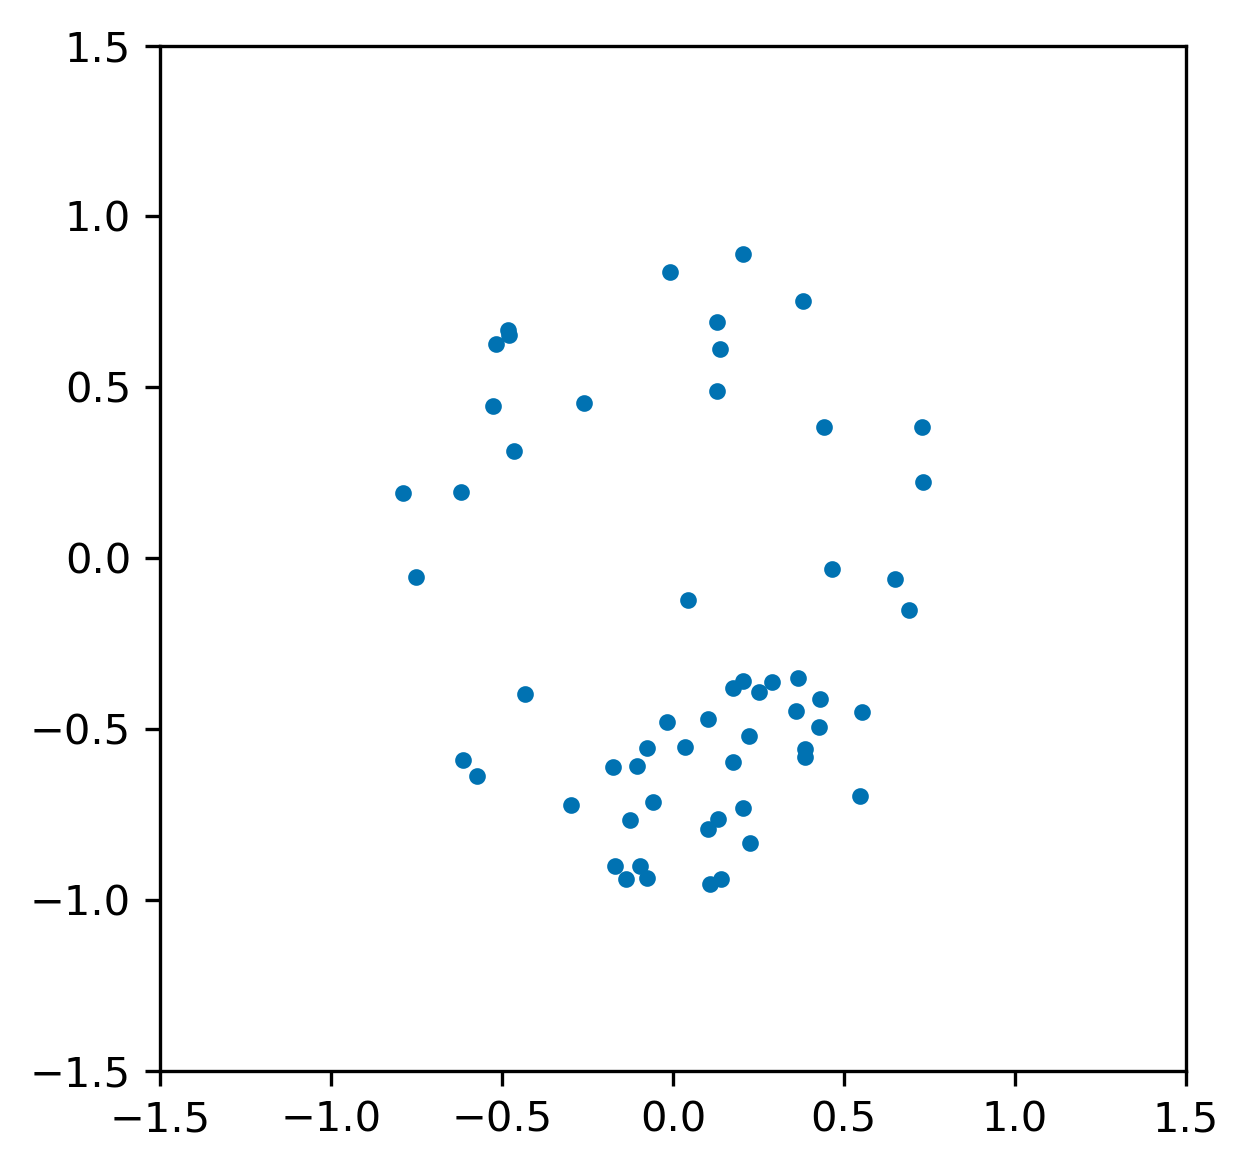

In [6]:
_, ax = plt.subplots(dpi=300)

best_idx = fit_history["fitness"].idxmax()
seed, gen, ind = fit_history[["seed", "generation", "individual"]].iloc[best_idx, :]
best = pop_histories[seed][gen][ind]

radii, angles = split_dataframe(best)
xs, ys = radii * np.cos(angles), radii * np.sin(angles)

ax.scatter(xs, ys, marker=".")
ax.set(
    xlim=(-1.5, 1.5),
    ylim=(-1.5, 1.5),
    aspect="equal",
)

plt.tight_layout()
plt.savefig("../img/circle_best.pdf", transparent=True)

In [7]:
xs_list, ys_list = [], []
for seed, history in enumerate(pop_histories):
    fit = fit_history[fit_history["seed"] == seed]
    upper_quantile = fit["fitness"].quantile(0.75)
    acceptable = fit[fit["fitness"] > upper_quantile][["generation", "individual"]]
    for _, (gen, ind) in acceptable.iterrows():

        individual = history[gen][ind]
        radii, angles = split_dataframe(individual)
        xs, ys = radii * np.cos(angles), radii * np.sin(angles)

        xs_list.extend(list(xs))
        ys_list.extend(list(ys))

In [8]:
xmin, xmax = ymin, ymax = -1.5, 1.5

xs, ys = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xs.ravel(), ys.ravel()])

values = np.vstack([xs_list, ys_list])
kernel = gaussian_kde(values)

zs = np.reshape(kernel(positions).T, xs.shape)

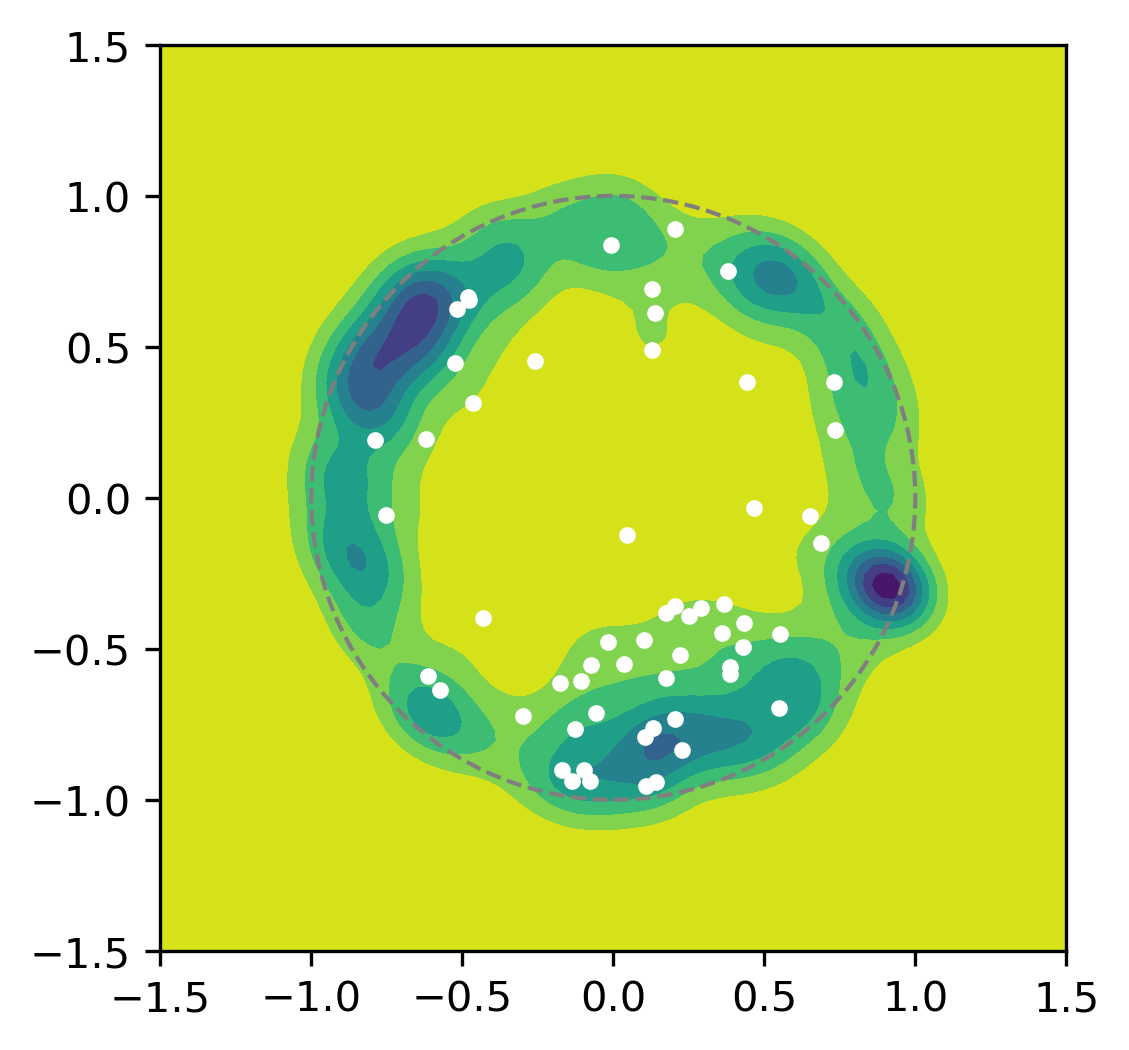

In [9]:
_, ax = plt.subplots(dpi=300)

ax.contourf(xs, ys, zs, cmap="viridis_r")

best_idx = fit_history["fitness"].idxmax()
seed, gen, ind = fit_history[["seed", "generation", "individual"]].iloc[best_idx, :]
best = pop_histories[seed][gen][ind]

radii, angles = split_dataframe(best)
best_xs, best_ys = radii * np.cos(angles), radii * np.sin(angles)

ax.scatter(best_xs, best_ys, color="white", marker=".")

circle = plt.Circle((0, 0), 1, fill=False, linestyle="--", color="tab:gray")
ax.add_artist(circle)

ax.set(
    xlim=(xmin, xmax),
    ylim=(ymin, ymax),
    aspect="equal",
)

# ax.axis("off")

plt.savefig("../img/circle_contour.pdf", transparent=True)